- 2021.03.19 運禽車軌跡
- 2021.06.18 更新:車軌鄰近禽場
- 2021.06.22 更新: 車軌鄰近禽場、停留點計算

# 車軌鄰近禽場 (從運禽車軌跡找 **接觸禽場**) 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, shape, Polygon
import folium
from folium import plugins
import datetime

# import sys
# sys.path.append('G:\我的雲端硬碟\python')
# import numpy as np
# from polib.MapToolkit import *
%matplotlib inline

## 讀入 禽場資料

In [2]:
farm_path = r"G:\我的雲端硬碟\work\2021\1.農試所_大禽流感專案\1.資料\畜牧場資料\Farms.json"
farm_df = pd.read_json(farm_path)
print(farm_df.info())
farm_df[["FarmName","lat","lng"]].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16115 entries, 0 to 16114
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   FarmID             16115 non-null  int64 
 1   field2             16115 non-null  object
 2   Epi_Pre_Num        16115 non-null  object
 3   field4             16115 non-null  object
 4   countyname         16115 non-null  object
 5   townname           16115 non-null  object
 6   VillageName        16115 non-null  object
 7   Address            16115 non-null  object
 8   FarmName           16115 non-null  object
 9   Owner              16115 non-null  object
 10  OwnerTEL           16115 non-null  object
 11  FarmStatus         16115 non-null  object
 12  NativeChicken      16115 non-null  int64 
 13  BreederForNC       16115 non-null  int64 
 14  Broiler            16115 non-null  int64 
 15  BreederForBroiler  16115 non-null  int64 
 16  Layer              16115 non-null  int64

,FarmName,lat,lng
0,林照成,,
1,永成牧場,24.32885800,120.60480700
2,蔡農家畜禽飼養場,24.32967000,120.60452900
3,振昇畜牧場,24.37435800,120.66589100
4,元益牧場,24.42578100,120.63230700


## 移除座標有缺值的禽場

In [3]:
# string -> float
farm_df.loc[:,"lat"] = pd.to_numeric(farm_df.loc[:,"lat"], errors='coerce')
farm_df.loc[:,"lng"] = pd.to_numeric(farm_df.loc[:,"lng"], errors='coerce')

In [4]:
farm_df.loc[:,["lat","lng"]].isnull().sum()

lat    4496
lng    4496
dtype: int64

In [5]:
print(f">> 原資料數: {len(farm_df)}")
farm_df.dropna(subset=["lat","lng"], how="any", inplace=True)
print(f">> 後資料數: {len(farm_df)}")

>> 原資料數: 16115
>> 後資料數: 11619


## 建立禽場 gdf

In [6]:
wgs84 = 'epsg:4326'
farm_gdf = gpd.GeoDataFrame(
    farm_df, geometry=gpd.points_from_xy(farm_df.lng, farm_df.lat)
    , crs=wgs84
)

In [2]:
# plot_points_on_folium(farm_gdf)

## 讀入 運禽車 資料

In [8]:
car_path = r"G:\我的雲端硬碟\python\output\0621\運禽車_TCP_0615to0617_20210621_15.47.45.pkl"
car_df = pd.read_pickle(car_path)

In [9]:
# 製作 日期 欄位
car_df.loc[:,"date"] = car_df.loc[:,"time"].dt.date

In [10]:
# 獨立車牌數
car_df["licensePlate"].nunique()

130

In [11]:
car_df["date"].unique()

array([datetime.date(2021, 6, 15), datetime.date(2021, 6, 16),
       datetime.date(2021, 6, 17)], dtype=object)

**只選用carStatus=1的資料作軌跡**

In [12]:
# 篩選 carStatus=1 (車在動的時候->30秒左右蒐集一次點位->比較不會有位置跳動過大的問題)
print(car_df["carStatus"].value_counts())
car_df = car_df[car_df["carStatus"].isin([1])].reset_index(drop=True)

0    97738
1    88745
Name: carStatus, dtype: int64


In [13]:
# 讀取其中一筆車牌
for driver in car_df["licensePlate"].unique()[3:4]: # 取1筆測試
    print(driver)
    # 讀取其中一天
    for date in car_df["date"].unique()[1:2]: # 取1筆測試
        print(date)
        mask = (car_df["licensePlate"].isin([driver])) & (car_df["date"].isin([date]))
        driver_df = car_df.loc[mask,:].reset_index(drop=True)
        print(len(driver_df))
driver_df.head()

035-H9
2021-06-16
105


,carStatus,time,lat,lon,speed,direction,licensePlate,date
0,1,2021-06-16 14:42:06,23.199959,120.217720,0,232,035-H9,2021-06-16
1,1,2021-06-16 14:42:37,23.199753,120.218292,22,128,035-H9,2021-06-16
2,1,2021-06-16 14:43:07,23.197720,120.219185,35,178,035-H9,2021-06-16
3,1,2021-06-16 14:43:38,23.194216,120.219505,46,176,035-H9,2021-06-16
4,1,2021-06-16 14:44:08,23.191982,120.219307,12,288,035-H9,2021-06-16


In [14]:
wgs84 = {'init': 'epsg:4326'}
driver_gdf = gpd.GeoDataFrame(
    driver_df, geometry=gpd.points_from_xy(driver_df.lon, driver_df.lat), crs=wgs84)

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [3]:
# # 總行車軌跡點位
# plot_points_on_folium(driver_gdf)

## 車軌 Buffer 100M

In [16]:
driver_geom = driver_gdf.sort_values(by=["time"])["geometry"].copy(deep=True)

### 車軌 需先轉換成 TWD97 121分帶 EPSG:3826 (單位: 公尺)

In [17]:
print(driver_geom.crs)
driver_geom_twd97 = driver_geom.to_crs("EPSG:3826")
print(driver_geom_twd97.crs)

+init=epsg:4326 +type=crs
EPSG:3826


### 將 車軌 從 點 轉換成 線

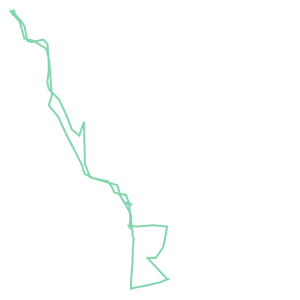

In [18]:
driver_geom_line = LineString(driver_geom_twd97.to_list())

driver_geom_line

In [19]:
driver_geom_line_buffer_100m = driver_geom_line.buffer(100)
# 需先將series 轉換回df 才能做交集
twd97 = {'init': 'epsg:3826'}

driver_geom_line_buffer_100m_df = gpd.GeoDataFrame(
    {'geometry': driver_geom_line_buffer_100m, 
     'temp':[True]}, 
     crs=twd97)

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [20]:
driver_geom_line_buffer_100m_df

,geometry,temp
0,"POLYGON ((167285.670 2570656.391, 167275.727 2...",True


### 禽場 需先轉換成 TWD97 121分帶 EPSG:3826 (單位: 公尺)

In [21]:
farm_gdf_twd97 = farm_gdf.to_crs("EPSG:3826")
farm_gdf_twd97[["geometry","lat","lng"]].head()

,geometry,lat,lng
1,POINT (209895.055 2691500.973),24.328858,120.604807
2,POINT (209867.098 2691590.985),24.329670,120.604529
3,POINT (216106.144 2696524.004),24.374358,120.665891
4,POINT (212714.268 2702227.942),24.425781,120.632307
5,POINT (211045.967 2694838.996),24.359026,120.616057


### 車軌 Buffer 與禽場點位取交集

In [22]:
# 只允許 gdf之間做交集
intersection_farms = gpd.overlay(farm_gdf_twd97, driver_geom_line_buffer_100m_df ,  how='intersection')
print(f">> 交集禽場數: {len(intersection_farms)}\n")

>> 交集禽場數: 9



## 畫圖

In [23]:
# 經 緯
locationlist = [[point.xy[1][0], point.xy[0][0]] for point in intersection_farms.to_crs('EPSG:4326').geometry ]

In [24]:
map = folium.Map(location=[23.762485, 120.827323], 
                 zoom_start=8, 
                 tiles='http://tile.stamen.com/toner/{z}/{x}/{y}.png', 
                 attr="https://stackoverflow.com/questions/48318538/folium-custom-map-tiles"
                )


# 運禽車完整路線Buffer
folium.Choropleth(
    driver_geom_line_buffer_100m_df,
    line_weight=3,
    line_color='#66B3FF',
    name="行車軌跡Buffer"
).add_to(map)

# # 交集禽場聚合(如果太多)
marker_cluster = plugins.MarkerCluster().add_to(map)

# (交集) 禽場 點位
for point in range(0, len(locationlist)):
    folium.CircleMarker(locationlist[point],
                        radius=7,
                        color='#808080',
                        fill=True,
                        fill_color='#3186cc'
                       ).add_to(marker_cluster)



# 加入底圖
folium.raster_layers.TileLayer(
    tiles = "https://wmts.nlsc.gov.tw/wmts/PHOTO2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
    attr = "國土測繪圖資服務雲",
    name="正射影像圖(通用版)",
#     overlay=True,
    min_zoom=0,
    max_zoom=19,
    ).add_to(map)
# folium.LayerControl().add_to(map)

folium.raster_layers.TileLayer(
    tiles = "https://wmts.nlsc.gov.tw/wmts/EMAP2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
    attr = "國土測繪圖資服務雲",
    name="臺灣通用電子地圖透明",
    show=False,
    overlay=True,
    min_zoom=0,
    max_zoom=19,
    ).add_to(map)
folium.LayerControl().add_to(map)

# map.save('從運禽車軌跡找接觸禽場.html')
map

# 停留點計算 (從運禽車軌跡找 **停留點**)

## 讀入 運禽車 資料

In [25]:
car_path = r"G:\我的雲端硬碟\python\output\0621\運禽車_TCP_0615to0617_20210621_15.47.45.pkl"
car_df = pd.read_pickle(car_path)

In [26]:
# 製作 日期 欄位
car_df.loc[:,"date"] = car_df.loc[:,"time"].dt.date

In [27]:
# 獨立車牌數
car_df["licensePlate"].nunique()

130

In [28]:
car_df["date"].unique()

array([datetime.date(2021, 6, 15), datetime.date(2021, 6, 16),
       datetime.date(2021, 6, 17)], dtype=object)

In [30]:
car_df["licensePlate"].unique()[:4]

['025-H9', '028-X6', '029-X6', '033-T6']
Categories (130, object): ['025-H9', '028-X6', '029-X6', '033-T6', ..., 'KLF-8237', 'KLG-5189', 'KLG-5355', 'UV-993']

In [31]:
# 讀取其中一筆車牌
driver = "029-X6" # 取1筆測試
mask = (car_df["licensePlate"].isin([driver]))
driver_df = car_df.loc[mask,:].reset_index(drop=True)
driver_df.head()

,carStatus,time,lat,lon,speed,direction,licensePlate,date
0,0,2021-06-15 14:52:26,23.596823,120.281693,0,290,029-X6,2021-06-15
1,0,2021-06-15 14:55:26,23.596817,120.281662,0,0,029-X6,2021-06-15
2,0,2021-06-15 14:58:26,23.596754,120.281654,0,0,029-X6,2021-06-15
3,0,2021-06-15 15:01:26,23.596754,120.281624,0,132,029-X6,2021-06-15
4,0,2021-06-15 15:04:26,23.596724,120.281715,0,122,029-X6,2021-06-15


In [32]:
wgs84 = {'init': 'epsg:4326'}
driver_gdf = gpd.GeoDataFrame(
    driver_df, geometry=gpd.points_from_xy(driver_df.lon, driver_df.lat), crs=wgs84)

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## 挑出有移動行為的日期

In [33]:
# 以X座標的變化來判斷當天是否有出車
date_X_nuniq_df = driver_df[["date", "lon"]].groupby("date").lon.nunique().reset_index()
date_X_nuniq_df

,date,lon
0,2021-06-15,36
1,2021-06-16,118
2,2021-06-17,42


## 判斷為有值勤的日期: 當日不重複X座標大於100個

In [34]:
move_date_lst = date_X_nuniq_df.loc[date_X_nuniq_df.lon>100, "date"]
move_date_lst

1    2021-06-16
Name: date, dtype: object

## 挑選日期

In [35]:
move_date = datetime.date(2021, 6, 16)
mask = driver_gdf.loc[:,"date"].isin([move_date])
driver_gdf_pic = driver_gdf[mask].reset_index(drop=True)

## 計算 每個獨立點位的停留時間

In [40]:
driver_gdf_pic.loc[:,"geometry_str"] = driver_gdf_pic.loc[:,"geometry"].astype(str)

計算各點位當日的時間的Max、Min

In [41]:
# 計算每個點位最大/最小的時間
point_time_range_gp = driver_gdf_pic.loc[:,["geometry_str","time"]].groupby("geometry_str",as_index=False)
#min
point_time_min_df = point_time_range_gp.min()
point_time_min_df.rename(columns={"time":"start_time"}, inplace=True)
#Max
point_time_max_df = point_time_range_gp.max()
point_time_max_df.rename(columns={"time":"end_time"}, inplace=True)

# 合併
point_time_sum_maxmin_df = driver_gdf_pic.merge(point_time_min_df, how="left", on="geometry_str")
point_time_sum_maxmin_df = point_time_sum_maxmin_df.merge(point_time_max_df, how="left", on="geometry_str")
point_time_sum_df = point_time_sum_maxmin_df.copy(deep=True)

In [42]:
# 計算停留時間
point_time_sum_df.loc[:,"stay_time"] = point_time_sum_df.loc[:,"end_time"] - point_time_sum_df.loc[:,"start_time"]

In [43]:
# Timestamp -> formated str
point_time_sum_df.loc[:,"start_time"] = point_time_sum_df.loc[:,"start_time"].dt.strftime("%Y/%m/%d, %H:%M:%S")
point_time_sum_df.loc[:,"end_time"] = point_time_sum_df.loc[:,"end_time"].dt.strftime("%Y/%m/%d, %H:%M:%S")

In [44]:
point_time_sum_gdf = gpd.GeoDataFrame(
    point_time_sum_df, geometry=gpd.points_from_xy(point_time_sum_df.lon, point_time_sum_df.lat), crs=wgs84)

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## 停留點條件篩選: **停留5分鐘以上，2小時以下**

In [45]:
point_time_sum_gdf.stay_time.describe()

count                          554
mean     0 days 00:39:15.034296028
std      0 days 02:50:22.093921583
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max                0 days 22:07:14
Name: stay_time, dtype: object

In [46]:
# 篩選條件 停留5分鐘以上，2小時以下
mask = (point_time_sum_gdf["stay_time"]>= datetime.timedelta(seconds=0, minutes=5, hours=0)) \
                & (point_time_sum_gdf["stay_time"]< datetime.timedelta(seconds=0, minutes=0, hours=2))

In [47]:
print(f">> 停留點數量: {len(point_time_sum_gdf[mask])}\n")

>> 停留點數量: 10



In [48]:
point_time_sum_gdf[mask].head()

,carStatus,time,lat,lon,speed,direction,licensePlate,date,geometry,geometry_str,start_time,end_time,stay_time
22,0,2021-06-16 01:07:27,23.596823,120.281715,0,114,029-X6,2021-06-16,POINT (120.28172 23.59682),POINT (120.2817153930664 23.59682273864746),"2021/06/16, 01:07:27","2021/06/16, 01:37:27",0 days 00:30:00
32,0,2021-06-16 01:37:27,23.596823,120.281715,0,50,029-X6,2021-06-16,POINT (120.28172 23.59682),POINT (120.2817153930664 23.59682273864746),"2021/06/16, 01:07:27","2021/06/16, 01:37:27",0 days 00:30:00
119,0,2021-06-16 05:58:27,23.596910,120.281662,0,0,029-X6,2021-06-16,POINT (120.28166 23.59691),POINT (120.2816619873047 23.59691047668457),"2021/06/16, 05:58:27","2021/06/16, 06:22:28",0 days 00:24:01
127,0,2021-06-16 06:22:28,23.596910,120.281662,0,168,029-X6,2021-06-16,POINT (120.28166 23.59691),POINT (120.2816619873047 23.59691047668457),"2021/06/16, 05:58:27","2021/06/16, 06:22:28",0 days 00:24:01
147,0,2021-06-16 07:22:28,23.596792,120.281631,0,0,029-X6,2021-06-16,POINT (120.28163 23.59679),POINT (120.2816314697266 23.59679222106934),"2021/06/16, 07:22:28","2021/06/16, 07:40:28",0 days 00:18:00


## 畫圖

In [49]:
locations = point_time_sum_gdf[mask][['lat', 'lon']]
locationlist = locations.values.tolist()

In [50]:
time_sums = point_time_sum_gdf[mask]['stay_time'].apply(lambda t: str(t).split("days")[1].split(".")[0])
time_sumslist = time_sums.values.tolist()

In [51]:
# (option)時間動畫

features = [{
    'geometry': {
        'coordinates': list(row['geometry'].coords)[0],
        'type': 'Point'
    },
    'properties': {
        'icon': 'marker',
        'iconstyle': {
            'iconSize': [40, 40],
            'iconUrl':
            'https://www.flaticon.com/svg/vstatic/svg/664/664468.svg?token=exp=1616138018~hmac=c04c6983e10730773e5f5f124f7b42e5'
        },
        'id': 'house',
        'popup': 1,
        'times': [row["start_time"],row["end_time"]]
    },
    'type': 'Feature'
}
    for idx,row in point_time_sum_gdf.iterrows()
]

In [56]:
map = folium.Map(location=[23.762485, 120.827323], 
                 zoom_start=8, 
                 tiles='http://tile.stamen.com/toner/{z}/{x}/{y}.png', 
                 attr="https://stackoverflow.com/questions/48318538/folium-custom-map-tiles"
                )

# 運禽車完整路線
folium.Choropleth(
    LineString(driver_gdf_pic[driver_gdf_pic["carStatus"].isin([1])].geometry.to_list()),
    line_weight=3,
    line_color='#66B3FF',
    name="行車軌跡"
).add_to(map)

# 停留點聚合(如果太多)
marker_cluster = plugins.MarkerCluster().add_to(map)

# 目標的停留時間 點位
for point in range(0, len(locationlist)):
    folium.CircleMarker(locationlist[point],
                        radius=10,
                        color='#3186cc',
                        fill=True,
                        popup=time_sumslist[point],
                        fill_color='#3186cc'
                       ).add_to(marker_cluster)
#                        ).add_to(map)


    
# # (option)加入時間
# plugins.TimestampedGeoJson(
#         {'type': 'FeatureCollection',
#         'features': features}
#         , period='PT2H' 
#         , duration='PT1M'
#         , add_last_point=False
#         , auto_play=True
#         , loop=False
#         , max_speed=1
#         , loop_button=True
#         , date_options='YYYY/MM/DD HH:mm:ss'
#         , time_slider_drag_update=True
#     ).add_to(map)

# 加入底圖
folium.raster_layers.TileLayer(
    tiles = "https://wmts.nlsc.gov.tw/wmts/PHOTO2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
    attr = "國土測繪圖資服務雲",
    name="正射影像圖(通用版)",
#     overlay=True,
    min_zoom=0,
    max_zoom=19,
    ).add_to(map)
# folium.LayerControl().add_to(map)

folium.raster_layers.TileLayer(
    tiles = "https://wmts.nlsc.gov.tw/wmts/EMAP2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
    attr = "國土測繪圖資服務雲",
    name="臺灣通用電子地圖透明",
    show=False,
    overlay=True,
    min_zoom=0,
    max_zoom=19,
    ).add_to(map)
folium.LayerControl().add_to(map)

map